# YOUR PROJECT TITLE

Imports and set magics:

In [1]:
import numpy as np
from scipy import optimize
import sympy as sm
import matplotlib.pyplot as plt

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2
#XD FOR SMART UPLOAD
# local modules
import modelproject

# Model description



We consider a Solow-model that incorporates fossil fuels and climate externalities 

 The model structure is 

1 $$Y_t=D_tK^\alpha _t(A_tL_t)^{\beta}E^{\epsilon}_t,\text{   }\alpha, \beta, \varepsilon \geq0, \alpha+\beta+\varepsilon=1$$

2 $$ K_{t+1}=sY_t+(1-\delta) K_t, \text{  } 0<\delta<1 $$

3 $$L_{t+1}=(1+n)L_t, \text{   } n\geq 0$$

4 $$A_{t+1}=(1+g)A_t, \text{   } g\geq 0$$

5 $$ R_{t+1}=R_t-E_t$$

6 $$ E_t=s_ER_t, \text{   } 0<s_E<\delta $$

7 $$ D_t=\left(\frac{R_t}{R_0}\right)^{\phi},\text{   }\phi\geq 0$$






* $K_t$ is capital
* $L_t$ is labor (growing with a constant rate of $n$)
* $E_t$ is "Oil" (where the amount used in each period is a fraction of the remaining reserve)
* $R_t$ is the remaining reserve of oil, $R_0$ is the initial reserve 
* $A_t$ is technology (growing with a constant rate of $g$)
* $D_t$ is the damage function
* $Y_t$ is GDP





Using the above equations, the following transition curve can be found 

$$z_{t+1} =\left(\frac{1}{1-s_E}\right)^{\varepsilon+\phi}\left(\frac{1}{(1+n)(1+g)}\right)^\beta (s+(1-\delta)z_t)^{1-\alpha})z_t^\alpha$$

where $z_t$ is the capital/output ratio $z_t=\frac{K}{Y}$
 

In [52]:
# First we consider the Solow model without climate externalities, that is we reduce the model to a Solow model extended with oil only, which is equal to setting phi to zero
# Parameters: 
epsilon = 0.1
beta = 0.6
alpha = 0.3
phi = 0 
delta =0.05
n = 0.01
g = 0.02
s =0.20
se = 0.005

In [53]:
# The condition for steady state, that is z(t) = z(t+1), is rewritten to give the following
obj_zss = lambda z: z- (1/(1-se))**(epsilon+phi)*((1/((1+n)*(1+g)))**beta)*((s+(1-delta)*z)**(1-alpha))*z**alpha

In [54]:
# Now we optimize using the "brentq" method 
Interval = [0.1,100]# An interval in which we expect to find the steady state, defined in a way so that we aviod the trivial steady state 

result = optimize.root_scalar(obj_zss,bracket=Interval,method="brentq")
print(f'The steady state for z is: z* = {result.root:.3f}')

The steady state for z is: z* = 2.663


In [5]:
# Now we introduce climate change in the form of the damage function, but allowing phi to take on various values 
phis=[0.2,0.4,0.6,0.8,1,1.2,1.4,1.6,1.8]


SS_list =[]
for phi in phis: # Obtaining various SS values for z by changing phi 
    result = optimize.root_scalar(obj_zss,bracket=Interval,method="brentq")
    SS_list.append(result.root)

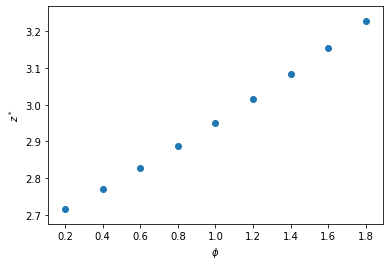

In [63]:
#Plotting relationship between steady state and phi
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
cs = plt.scatter(phis,SS_list)
ax.set_xlabel('$\phi$')
ax.set_ylabel('$z^*$');

Simulation

We create functions of the model equations we introduced earlier:

In [7]:
def Y(D,K,A,L,E,a,b,e):
    return D*(K**a)*((A*L)**b)*(E**e)
def D_t(R,R_0,phi):
    return (R/R_0)**phi
def A_t1(A,g):
    return A*(1+g)
def L_t1(L,n):
    return L*(1+n)
def K_t1(s,Y,d,K):
    return s*Y+(1-d)*K
def R_t1(R,E):
    return R-E
def E_t(sE,R):
    return sE*R    

Then we create a function to simulate the model

In [81]:
def simulate(K0,A0,L0,R0,periods,a=0.3,b=0.6,e=0.1,g=0.02,n=0.01,s=0.2,phi=1,sE=0.005,d=0.05):
    """Simulates the Solowmodel for given starting values of capital, labour, technology and fossil fuels aswell as given model parameters""" 

# First we generate lists to store the output for each endogenus variabel and add/calculate the period 0 values:

    listA = [A0]
    listK = [K0]
    listL = [L0]
    listR = [R0]
    listD = [1]   # The damage function will always be 1 in period 0, since R_t=R_0 -> (R_t/R_0)^phi=1
    listE = [E_t(sE = sE, R = R0)]
    listY = [Y(listD[-1], K0, A0, L0, listE[-1], a = a, b = b, e = e)]
    listt = [0] # We always start in period t=0, so the first element in t is 0

    # Now we simulate for the amount of periods specified:
    i = 1 # Where i indicates the period, so we start by simulating periode t=0+1=1
    # The following calculations are done in order of causality, so we can call the last element in the needed variable list, therefore Y has to be done last, so the last element in K, A, L and so on has already been updated for the current period.
    while i <= periods:
        listA.append(A_t1(listA[-1],g = g))
        listK.append(K_t1(Y = listY[-1], K = listK[-1], s = s, d = d))
        listL.append(L_t1(listL[-1], n = n))
        listR.append(R_t1(listR[-1], E = listE[-1]))
        listE.append(E_t(R = listR[-1], sE = sE))
        listD.append(D_t(R = listR[-1], R_0 = R0, phi = phi))
        listY.append(Y(D = listD[-1],K = listK[-1],A = listA[-1],L = listL[-1],E = listE[-1], a = a, b = b, e = e))
        listt.append(i)
        i+=1
    
# We return the lists for Y, L, K, t and D as they are the variables we are interested in analyzing.
    return listY, listL, listK, listt, listD, listR

In [104]:
# We define a list of phi values we want to analyze
philist = [0, 0.5, 1, 2]

# Then we simulate a list containing 4 lists of the Y, K and D values for each phi value in philist. The [0] and [2] are because the simulate function returns 5 lists with Y being index 0 and K beign index 2 etc.
ylist = np.array([simulate(1,1,1,1, 2000, phi = phi)[0] for phi in philist]) 
klist = np.array([simulate(1,1,1,1, 2000, phi = phi)[2] for phi in philist])
dlist = np.array([simulate(1,1,1,1, 2000, phi = phi)[4] for phi in philist])
llist = simulate(1,1,1,1,2000)[1]
tlist = simulate(1,1,1,1,2000)[3]
rlist = simulate(1,1,1,1,2000)[5]
# Then we calculate the capital-income-ratio, z, by dividing K with Y
zlist = np.divide(klist,ylist)
lowercaseylist = np.divide(ylist,llist)

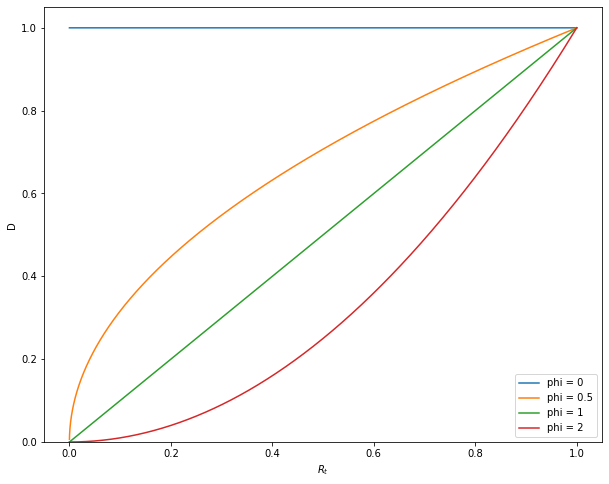

In [101]:
# We create the figure object
damagefig = plt.figure(figsize = [10, 8])
ax = fig.add_subplot(1,1,1)
# Then we add the dataseries
plt.plot(rlist, dlist[0], label = "phi = 0")
plt.plot(rlist, dlist[1], label = "phi = 0.5")
plt.plot(rlist, dlist[2], label = "phi = 1")
plt.plot(rlist, dlist[3], label = "phi = 2")
plt.legend()
plt.ylabel("D")
plt.xlabel("$R_t$")
# We define the lower limit of the y-axis
plt.ylim(bottom = 0);

# Further analysis

ADD FURTHER ANALYSIS, VISUALIZATIONS AND EXTENSIONS.

# Conclusion

ADD CONCISE CONCLUSION.